In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#**IST 707 - HW4 - Statistical Learning, Deep Learning & A Complete Comparison**

**Performed by Nisha Rangnani**

**4/26/2020**

In this assignment, I'll be predicting if an individual has the disease or not in the given Test dataset. I would be implementing Logistic regression, Decision tree learning, Artificial Neural Network with 0, 1 and 2 hidden layers to achieve the prediction results.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from keras import models
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.tree import DecisionTreeClassifier

Using TensorFlow backend.


Import all the libraries required for processing. Then, read the training and testing datasets into appropriate dataframes.

In [0]:
DATASET_PATH = 'gdrive/My Drive/Nisha/MS_ADS/DA/'
TRAIN_PATH = DATASET_PATH + 'disease_train.csv'
TEST_PATH = DATASET_PATH + 'disease_test.csv'

OUTPUT_COL = 'Disease'
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_test_copy = df_test

**Explore the training and testing dataframes.**

In [6]:
df_train.shape

(49000, 12)

In [146]:
df_test.shape

(21000, 12)

In [147]:
df_train.describe()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease
count,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000
mean,52.853306,164.366878,74.190527,128.698939,96.917367,0.088265,0.054245,0.803204,0.499959
std,6.763065,8.216637,14.329934,147.624582,200.368069,0.283683,0.226503,0.397581,0.500005
min,29.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,207.000000,200.000000,14020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000


In [148]:
df_test.describe()

,ID,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,10499.500000,52.811190,164.341381,74.241070,129.093429,95.960857,0.087810,0.052667,0.804952
std,6062.322162,6.775489,8.195082,14.548468,167.975674,157.257409,0.283024,0.223372,0.396247
min,0.000000,29.000000,64.000000,21.000000,10.000000,-70.000000,0.000000,0.000000,0.000000
25%,5249.750000,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000
50%,10499.500000,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000
75%,15749.250000,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000
max,20999.000000,64.000000,250.000000,183.000000,16020.000000,8500.000000,1.000000,1.000000,1.000000


In [149]:
df_train.head(7)

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0
5,54,female,163,61.0,120,80,normal,normal,0,0,1,0
6,48,female,159,89.0,150,90,high,high,0,0,1,1


**Now let us explore and see if we have any missing values in our data.**

In [150]:
df_train.isna().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

In [151]:
df_test.isna().sum()

ID                     0
Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

**From above results, we can see that there are no missing values.**
**Let us explore if we have any duplicate data.**

In [7]:
df_train[df_train.duplicated(subset=None, keep='first')].head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
1278,40,female,156,65.0,110,80,normal,normal,0,0,1,0
1581,56,female,160,60.0,120,80,normal,normal,0,0,1,1
1901,54,female,170,80.0,120,80,normal,normal,0,0,1,0
2412,41,female,162,65.0,110,70,normal,normal,0,0,1,0
3027,56,female,169,70.0,120,80,normal,normal,0,0,1,0


**We can see that there are 1752 duplicate rows.**
**So, let us deal with duplicates by dropping them.**

In [0]:
df_train.drop_duplicates(keep='first',inplace=True)

In [9]:
df_train[df_train.duplicated(subset=None, keep='first')]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease


**From above result we can note that there are no more duplicates left.**

**Let's store ID's separately and drop them from test set to be able to proceed for model building activities.**

In [0]:
df_IDs = df_test['ID']
df_test = df_test.loc[:, df_test.columns != 'ID']

**From describe(), we can see that Low Blood Pressure and High Blood Pressure fields have strange values.** 
**We can see that even have negative values for BP in train as well as test set.** 
**From the research performed on BP range, we can set Lower BP range as 30-180 and higher BP range as 80-220 and transform data accordingly.** 
**Since we have decided upon a range, if the number is outside the range, we can simply trim it.**

In [0]:
df_train['High Blood Pressure'].clip(lower = 80, upper = 220, inplace = True)

In [0]:
df_train['Low Blood Pressure'].clip(lower = 30, upper = 180, inplace = True)

In [13]:
df_test['High Blood Pressure'].clip(lower = 80, upper = 220, inplace = True)
df_test['Low Blood Pressure'].clip(lower = 30, upper = 180, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:7363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


**Let us now deal with noisy data - where High Blood Pressure is lesser than Low BP.**


**For cases where High BP is lesser than Low BP, it has most probably happened due an error in data entry. That is, by mistake Low BP was entered in place of High BP and vice versa. Thus, lets write a function to check High BP and Low BP values, and swap them wherever necessary.**

In [0]:
def col_switch_lowHighBP(df):
  index=df.index
  l=len(index)
  for i in range(0,l):
    if(df.iloc[i]['High Blood Pressure']<df.iloc[i]['Low Blood Pressure']):
      temp = df.iloc[i]['High Blood Pressure']
      df.iloc[i]['High Blood Pressure'] = df.iloc[i]['Low Blood Pressure']
      df.iloc[i]['Low Blood Pressure'] = temp


In [15]:
col_switch_lowHighBP(df_train)
col_switch_lowHighBP(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Below section is introduced specifically for running decision tree classifier.** 
**Store train and test DF for Decision Tree separately.**
**Convert categorical data to numerical and feed it to the classifier.**

In [162]:
df_train_dt = df_train
df_test_dt = df_test
df_train_dt['Gender'].replace('female',1,inplace=True)
df_train_dt['Gender'].replace('male',0,inplace=True)
df_test_dt['Gender'].replace('female',1,inplace=True)
df_test_dt['Gender'].replace('male',0,inplace=True)
df_train_dt['Cholesterol'].replace(['normal','high','too high'],[1,2,3],inplace=True)
df_train_dt['Glucose'].replace(['normal','high','too high'],[1,2,3],inplace=True)
df_test_dt['Cholesterol'].replace(['normal','high','too high'],[1,2,3],inplace=True)
df_test_dt['Glucose'].replace(['normal','high','too high'],[1,2,3],inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Exploratory Data Analysis

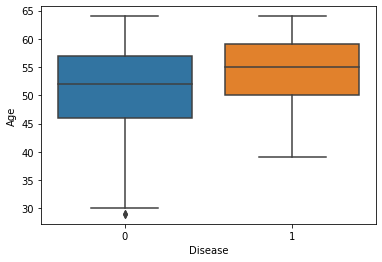

In [163]:
import seaborn as sns
sns.boxplot(x=df_train['Disease'], y=df_train['Age'])

**I explored Age variable for both Disease=Yes and No (1,0). From above plot, we can observe that usually, overall age is higher in case of Disease being present. For younger age people, we see that the disease is absent.**

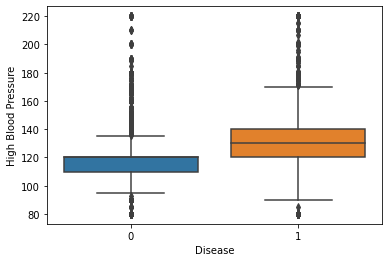

In [164]:
sns.boxplot(x=df_train['Disease'], y=df_train['High Blood Pressure'])

**On exploring Disease with respect to the High Blood Pressure data, we can note that in case of Disease = Yes(=1), mean of High BP is significantly higher than in case of Disease = No.**
**Thus, as High BP rises, the risk of getting the disease is likely to rise.**

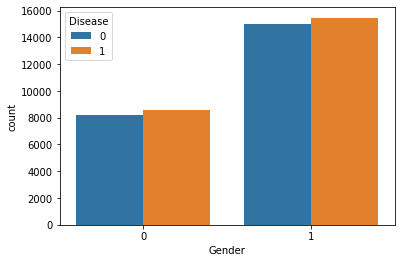

In [165]:
sns.countplot(data=df_train, x='Gender', hue='Disease')

**On exploring the dataset in terms of Disease and Gender, we can see that for both genders, count of getting the disease is higher individually. Also, from the overall chart, we have more female patient records than males.**

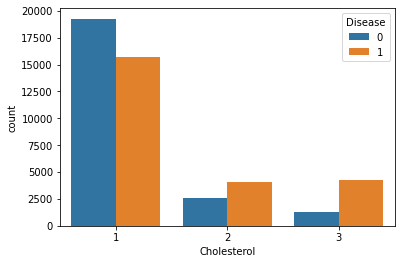

In [166]:
sns.countplot(data=df_train, x='Cholesterol', hue='Disease')

**From above plot, we can understand that when cholesterol level is Normal, more patients do NOT have the disease. But in case of High and and very high cholesterol, more patients tend to get the disease. When cholesterol level is  'too high', most patients are detected with the disease.** 

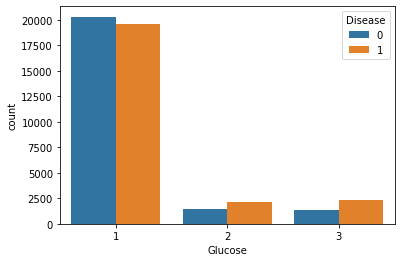

In [167]:
sns.countplot(data=df_train, x='Glucose', hue='Disease')

**Similar to cholesterol level, when glucose level is normal, more patients do not have the disease as compared to patients having the disease. But when glucose level goes to high and too high, more percentage of people have the disease.**

**Now that we have explored our data, let us create dummy variables in order to get rid of categorical variables and get our data ready for Logistic regression and artificial neural networks.**

In [16]:
dummyVar=['Gender','Cholesterol','Glucose']
df_train = pd.get_dummies(df_train, columns=dummyVar, prefix_sep="-")
df_train.head()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease,Gender-female,Gender-male,Cholesterol-high,Cholesterol-normal,Cholesterol-too high,Glucose-high,Glucose-normal,Glucose-too high
0,59,167,88.0,130,68,0,0,1,0,1,0,0,1,0,0,1,0
1,64,150,71.0,140,100,0,0,0,1,1,0,0,1,0,0,1,0
2,41,166,83.0,100,70,0,1,1,0,1,0,0,1,0,0,1,0
3,50,172,110.0,130,80,1,0,1,0,0,1,0,1,0,0,1,0
4,39,162,61.0,110,80,0,0,1,0,1,0,1,0,0,1,0,0


From above table we can understand that dummy variable columns were created from Gender, cholesterol and glucose attributes and their original columns were dropped. Same is performed below for the test dataset as well.

In [0]:
df_test = pd.get_dummies(df_test, columns=dummyVar, prefix_sep="-")

**Now that our data is ready for our machine learning models, lets split it into train-test validation set in 70:30 ratio so that we're able to judge our model performance.**
**Apply LogisticRegrssion() to the train set obtained and predict values for the remaining 30% test set.** 

In [18]:
X = df_train.drop('Disease', axis=1)
y = df_train['Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
logr_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logr_pipe.fit(X_train,y_train)
y_pred = logr_pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.731710758377425


**We obtained an accuracy of 73.17% for our default LR(). Let's obtain the recall_score for the same.  Since we're dealing with Disease prediction problem, I'll go ahead with measuring Recall for model evaluation, as to predict if the person has the disease. Here, we can afford to have False positives. False negatives (predicting that they do not have disease, and end up having the disease) is more harmful here.**

In [173]:
print(recall_score(y_test, y_pred))

0.6915849108746718


### **Hyperparameter tuning**


In [174]:
logr= LogisticRegression()
parametersLogr = {'penalty':['l1','l2','elasticnet','none'],'solver': ['liblinear','newton-cg','lbfgs','sag','saga'],'C':[0.01,0.1,1,11.1], 'multi_class':['auto', 'ovr', 'multinomial']}
logr_grid = GridSearchCV(logr, parametersLogr, n_jobs=-1, cv=4)

logr_grid.fit(X,y)
logr_grid.best_params_

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

**Now that we have our best performing parameters - lets calculate the accuracy score again. Post this, we can go ahead with predicting the class variable for our actual testing dataset.**

**Here's the summary of default values taken for LogisticRegression() and values for parameters obtained after GridSearch optimization along with their respective accuracies.**

**[parameters : accuracy]**

**1. LogisticRegression(solver='lgbfs') : 73.17% .** 

**2. {C:1, multi_class:'ovr', penalty:'l1', solver:'liblinear'} : 73.21%**

In [175]:
logr_grid.fit(X_train,y_train)
y_pred = logr_grid.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7321340388007055


In [0]:
logr_pred = logr_grid.predict(df_test)

**Let us now plot the Receiver Operating Characteristics curve and find out area under the curve.**

In [0]:
def plotROC(pred_mod,X,y):
    mod_proba = pred_mod.predict_proba(X)
    mod_proba = mod_proba[:, 1]
    auc = metrics.roc_auc_score(y, mod_proba)
    print('ROC AUC=%.3f' % (auc))
    fpr, tpr, _ = metrics.roc_curve(y, mod_proba)
    plt.plot(fpr, tpr, marker='.', label='Classifier')
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC Curve')
    plt.xlabel('FPRate')
    plt.ylabel('TPRate')
    plt.legend()
    plt.show()

ROC AUC=0.792


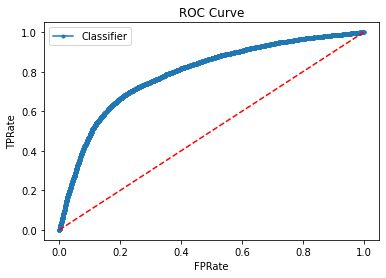

In [178]:
plotROC(logr_grid,X_test, y_test)

**Let's scale the data before proceeding for deep learning**

In [0]:
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
df_test=scaler.transform(df_test)

#Artificial Neural Network

**ANN with Zero Hidden Layers**

In [264]:
model=Sequential()
model.add(Dense(1,activation='sigmoid',input_dim=16))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
import keras
ES = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, mode='auto', patience=5, verbose=0)

**Implement callback in order to stop execution of model when the result is achieved. This will help save time in model execution.**

**Displaying parameters of the best working model below.**

**Find a display of various parameters used and their respective accuracies later in the report.**

In [308]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=16, callbacks=[ES])

Epoch 1/200
33073/33073 [==============================] - 2s 63us/step - loss: 0.5616 - accuracy: 0.7259
Epoch 2/200
33073/33073 [==============================] - 2s 64us/step - loss: 0.5618 - accuracy: 0.7259
Epoch 3/200
33073/33073 [==============================] - 2s 64us/step - loss: 0.5619 - accuracy: 0.7256
Epoch 4/200
33073/33073 [==============================] - 2s 63us/step - loss: 0.5618 - accuracy: 0.7273
Epoch 5/200
33073/33073 [==============================] - 2s 63us/step - loss: 0.5619 - accuracy: 0.7255
Epoch 6/200
33073/33073 [==============================] - 2s 65us/step - loss: 0.5617 - accuracy: 0.7261


In [309]:
y_pred = model.predict_classes(X_test)
print(accuracy_score(y_test, y_pred))

0.7321340388007055


In [310]:
print(recall_score(y_test, y_pred))

0.6841232554926074


**Hyperparameter tuning for ANN with 0 hidden layers**
1. loss=binary_crossentropy, optimizer='sgd', epochs=20, batchsize=1 : 72.64%
2. loss=binary_crossentropy, optimizer='Adam', epochs=30, batchsize=4 : 73.21%
3. loss=binary_crossentropy, optimizer='Adam', epochs=40, batchsize=8 : 73.29%

Finally, use the best working model to predict class variable Disease for the testing dataset.

In [0]:
ann0_pred = model.predict_classes(df_test)
ann0_pred = ann0_pred.flatten()

Comparison of Linear SVM, Logistic Regression, Single Layer Perceptron performance
Accuracy of final model :
1. Linear SVM : 73.2%
2. Logistic Regression : 73.21%
3. Single Layer Perceptron : 73.29%

Final hyperparameters that gave above accuracy:
1. Linear SVM : {max_iter = 4000, multi_class = 'crammer_singer'}
2. Logistic Regression : {C:1, multi_class : 'ovr', penalty : 'l1', solver : 'liblinear'}
3. Single Layer Perceptron : {loss = 'binary_crossentropy', optimizer = 'Adam', epochs = 40, batchsize = 8}

All the above algorithms have a similar performance, with less than a 0.1% difference in their accuracy.

Theoretically, SVM is based on geometrical properties of data whereas Logistic Regression is based on statistical practices.
The risk of overfitting is less SVM. However, logistic regression is vulnerable to overfitting.
Both SVM and LR perform well even with less data. Neural networks need large amounts of data. 
Neural networks are comparatively much slower than SVM and LR. But they tend to give better overall accuracy.

## **ANN with one hidden layer:**

In [313]:
model1 = Sequential()
model1.add(Dense(6, activation='relu', input_dim=16))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 7         
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


**Displaying parameters of the best working model below.**

**Find a display of various parameters used and their respective accuracies later in the report.**

In [314]:
model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=200, batch_size=16, callbacks=[ES])

Epoch 1/200
33073/33073 [==============================] - 2s 74us/step - loss: 0.5935 - accuracy: 0.6995
Epoch 2/200
33073/33073 [==============================] - 2s 70us/step - loss: 0.5534 - accuracy: 0.7300
Epoch 3/200
33073/33073 [==============================] - 2s 66us/step - loss: 0.5498 - accuracy: 0.7312
Epoch 4/200
33073/33073 [==============================] - 2s 68us/step - loss: 0.5480 - accuracy: 0.7310
Epoch 5/200
33073/33073 [==============================] - 2s 68us/step - loss: 0.5467 - accuracy: 0.7315
Epoch 6/200
33073/33073 [==============================] - 2s 65us/step - loss: 0.5462 - accuracy: 0.7312
Epoch 7/200
33073/33073 [==============================] - 2s 66us/step - loss: 0.5458 - accuracy: 0.7323
Epoch 8/200
33073/33073 [==============================] - 2s 67us/step - loss: 0.5454 - accuracy: 0.7335
Epoch 9/200
33073/33073 [==============================] - 2s 67us/step - loss: 0.5450 - accuracy: 0.7325
Epoch 10/200
33073/33073 [====================

In [315]:
y_pred = model1.predict_classes(X_test)
print(accuracy_score(y_test, y_pred))

0.732910052910053


In [316]:
print(recall_score(y_test, y_pred))

0.7207406383860716


**Hyperparameter tuning**

1. loss=binary_crossentropy, optimizer='sgd', epochs=20, batchsize=1, verbose=1 : 49.29%
2. loss=binary_crossentropy, optimizer='Adam', epochs=30, batchsize=4 : 73.23%
3. loss=binary_crossentropy, optimizer='Adam', epochs=40, batchsize=8 : 73.45%

**Use the best working model to predict the class variable Disease for the main testing dataset.**

In [0]:
ann1_pred = model1.predict_classes(df_test)

In [0]:
ann1_pred = ann1_pred.flatten()

## **ANN with 2 hidden layers**

In [321]:
model2 = Sequential()
model2.add(Dense(6, activation='relu', input_dim=16))
model2.add(Dense(6,activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 7         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


**Displaying the model with best working parameters below.**

**A summary of different parameters used along with their respective accuracies would be shown later in the report.**

In [322]:
model2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=200, batch_size=16, callbacks=[ES])

Epoch 1/200
33073/33073 [==============================] - 3s 76us/step - loss: 0.5805 - accuracy: 0.7081
Epoch 2/200
33073/33073 [==============================] - 2s 73us/step - loss: 0.5539 - accuracy: 0.7259
Epoch 3/200
33073/33073 [==============================] - 2s 69us/step - loss: 0.5490 - accuracy: 0.7301
Epoch 4/200
33073/33073 [==============================] - 2s 75us/step - loss: 0.5468 - accuracy: 0.7304
Epoch 5/200
33073/33073 [==============================] - 2s 75us/step - loss: 0.5454 - accuracy: 0.7314
Epoch 6/200
33073/33073 [==============================] - 2s 73us/step - loss: 0.5446 - accuracy: 0.7323
Epoch 7/200
33073/33073 [==============================] - 2s 72us/step - loss: 0.5440 - accuracy: 0.7327
Epoch 8/200
33073/33073 [==============================] - 2s 72us/step - loss: 0.5436 - accuracy: 0.7321
Epoch 9/200
33073/33073 [==============================] - 2s 71us/step - loss: 0.5431 - accuracy: 0.7329
Epoch 10/200
33073/33073 [====================

In [323]:
y_pred = model2.predict_classes(X_test)
print(accuracy_score(y_test, y_pred))

0.7339682539682539


In [324]:
print(recall_score(y_test, y_pred))

0.69849385104325


**Hyperparameter tuning**

1. loss=binary_crossentropy, optimizer='sgd', epochs=20, batchsize=1 : 73.33%

2. loss=binary_crossentropy, optimizer='Adam', epochs=30, batchsize=4 : 73.35%

3. loss=binary_crossentropy, optimizer='Adam', epochs=40, batchsize=8 : 73.46%

**Finally, use the best working model to predict the class variable Disease for the testing dataset.**

In [0]:
ann2_pred = model2.predict_classes(df_test)

In [0]:
ann2_pred = ann2_pred.flatten()

## **Decision Tree Classifier**

In [0]:
OUTPUT_COL = 'Disease'
df_X = df_train_dt.loc[:, df_train_dt.columns != OUTPUT_COL]
df_y = df_train_dt[OUTPUT_COL]

df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_X, df_y, test_size=0.3, random_state=47)

**Use the train and test dataframes created specifically for decision tree and split them into 70:30 ratio.**

**Train the classifier with default parameters and check accuracy.**

In [193]:
dtc = DecisionTreeClassifier(random_state=47).fit(df_train_X, df_train_y)

val_pred_dtc = dtc.predict(df_val_X)
print(accuracy_score(df_val_y, val_pred_dtc))

0.6214462081128748


## **Hyperparameter tuning**

**Let us now fine tune the model to improve its performance using GridSearchCV() and extracting parameters that lead to the best performing model.**

In [194]:
dc= DecisionTreeClassifier()
parametersDT = {'criterion':['gini','entropy'],'min_samples_split':[2,5,9,11], 'max_depth':[5,8,13], 'min_samples_leaf':[5,9,13], 'max_leaf_nodes':[40,50,60], 'random_state':[23,47]}
dt_grid = GridSearchCV(dc, parametersDT, n_jobs=-1, cv=4)

dt_grid.fit(df_train_X,df_train_y)
dt_grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 13,
 'min_samples_split': 2,
 'random_state': 23}

In [195]:
y_pred = dt_grid.predict(df_val_X)
print(accuracy_score(df_val_y, y_pred))

0.7331216931216932


In [196]:
print(recall_score(df_val_y, y_pred))

0.6946280991735537


**Summary of [model parameters : accuracy]**
1. [DecisionTreeClassifier(random_state=47) : 62.14%]

Post hyperparamter tuning, parameters yielding maximum accuracy:

2. [{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 40, 'min_samples_leaf': 13, 'min_samples_split': 2, 'random_state': 23} : 73.31%]

**Let us now use the model with best performance to classify Disease as Yes/No (1/0) for the final testing dataset.** 

In [0]:
dt_pred = dt_grid.predict(df_test_dt)

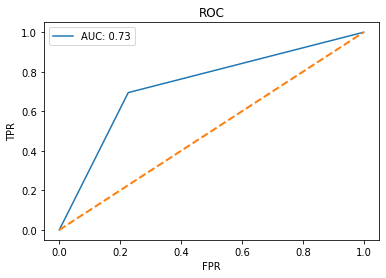

In [198]:
fpr, tpr, threshold = roc_curve(df_val_y, y_pred)
plt.plot(fpr, tpr, label='AUC: %0.2f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], '--', lw=2)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

**Thus, area under the curve for decision tree ROC curve is 0.73.**

#Model Performance Summary

**Name of Algorithm  ||  Key Hyperparameters Tuned  ||     Accuracy    ||  Recall  ||  Time to Run**

________________________________________________________________________________
Gradient Boost || loss, n_estimators || 73.9% || 71.14 || 6 seconds

Non-linear SVM (RBF) || kernel, C, gamma || 73.9% || 69.22 || 18 seconds

ANN with 2 Hidden || loss, optimizer, epochs, batchsize || 73.46% || 67.86 || 3 mins 5 secs

ANN with 1 Hidden || loss, optimizer, epochs, batchsize || 73.45% || 68.71 || 2 mins 51 secs

Decision Tree || criterion, max_depth, max_leaf_nodes, min_samples_leaf, min_samples_split, random_state || 73.31% || 69.46 || 2 secs

ANN with 0 Hidden || loss, optimizer, epochs, batchsize || 73.29% || 69.14 || 2 mins 39 secs

Logistic Regression || C, multi_class, penalty, solver ||  73.17% || 69.16 || 3 secs

Linear SVM || max_iter, multi_class || 73.17% || 65.1 || 12 secs

K-Nearest Neighbors || n_neighbors, p, leaf_size || 72.71% || 69.18 || 3 secs

Random Forest || n_estimators, max_features || 71.27% || 71.67 || 3 secs

Naive Bayes  ||  Default  || 69.63% || 56.04 || 2 secs



Thus, to summarize, overall accuracy range lie between 69 to 74%. Gradient boost provides with the highest accuracy and is one of the fastest algorithms. Non-linear SVM using RBF function, decision tree, logistic regression, linear SVM also provide with top accuracies and take very little time to run. ANN with 0 hidden layers, 1 and 2 hidden layers provide top accuracies, but take up time to run. Other algorithms such as KNN, RF and Naive bayes do not take much time, but they do not provide very high accuracy score.

In [0]:
#feature importance
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.ensemble import RandomForestClassifier

df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X, y, test_size=0.3, random_state=47)

model_rf = RandomForestClassifier(n_estimators=45, max_features=2)
model_rf.fit(df_train_X, df_train_y)
rfc_pred = model_rf.predict(df_val_X)

model_g = gbm(loss='exponential', n_estimators=103)
model_g.fit(df_train_X, df_train_y)
gbm_pred = model_g.predict(df_val_X)

In [23]:
f_imp_rf = pd.DataFrame(model_rf.feature_importances_, index=X.columns, columns=['imp']).sort_values('imp',ascending=False)
f_imp_rf

,imp
Weight,0.233937
Height,0.204706
Age,0.191057
High Blood Pressure,0.179380
Low Blood Pressure,0.108566
Cholesterol-too high,0.019389
Cholesterol-normal,0.014791
Exercise,0.011252
Smoke,0.006901
Alcohol,0.006062


Above is feature importance table from Random Forest model built. It has been sorted in a descending order of importance of features from the main dataset. Thus, from the perspective of RF, weight is most important, followed by Height, then age and so on.

In [22]:
f_imp_gb = pd.DataFrame(model_g.feature_importances_, index=X.columns, columns=['imp']).sort_values('imp',ascending=False)
f_imp_gb

,imp
High Blood Pressure,0.714135
Age,0.124201
Cholesterol-too high,0.054037
Low Blood Pressure,0.029356
Weight,0.025050
Cholesterol-normal,0.023638
Height,0.008991
Exercise,0.005597
Glucose-too high,0.003421
Smoke,0.003249


Above is feature importance table from Gradient Boosting Machine model built. It has been sorted in a descending order of importance of variables from the dataset. Thus, from the perspective of GBM, High Blood Pressure is most important, followed by Age, then Cholesterol level and so on.

**Finally, push results in a csv file:**

In [0]:
final = {
    'ID' : df_test_copy.ID,
    'DT' : dt_pred,
    'LR' : logr_pred,
    'ANN0' : ann0_pred,
    'ANN1' : ann1_pred,
    'ANN2' : ann2_pred
}

In [0]:
final_df = pd.DataFrame(final)
final_df.to_csv('FinalOutputDis.csv')